In [1]:
import gpytorch
import numpy as np
import torch
import winsound
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from LDGD.model import LDGD, FastLDGD, VAE
from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm, plot_box_plots
from LDGD.data.data_loader import generate_data

from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood

from LDGD.utils import dicts_to_dict_of_lists
import json
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Compare_decoding_on_dataset.ipynb# Functions

## 1- Create Dataset

In [2]:
def create_dataset(num_dimension, random_state, test_size, **kwargs):
    # Extract parameters for synthetic data generation
    pattern = kwargs.get('pattern', 'moon')  # default pattern
    n_samples = kwargs.get('n_samples', 1500)
    noise = kwargs.get('noise', 0.1)
    increase_method = kwargs.get('increase_method', 'linear')

    X, y, orig_data = generate_data(pattern, n_samples, noise, num_dimension, increase_method, random_state=random_state)
    # One-hot encode the labels
    y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
    y_one_hot[np.arange(y.shape[0]), np.uint(y)] = 1

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(X, y_one_hot, y,
                                                                                       test_size=test_size,
                                                                                       random_state=random_state)
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    y_train_labels_tensor = torch.tensor(y_train_labels)
    y_test_labels_tensor = torch.tensor(y_test_labels)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_labels_tensor, y_test_labels_tensor, orig_data



## 2 - Create Model

In [3]:
def create_LDGD_model(data_cont, data_cat, ldgd_settings, batch_shape, x_init='pca'):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = LDGD(data_cont,
                 kernel_reg=kernel_reg,
                 kernel_cls=kernel_cls,
                 num_classes=data_cat.shape[-1],
                 latent_dim=ldgd_settings['latent_dim'],
                 num_inducing_points_cls=ldgd_settings['num_inducing_points_cls'],
                 num_inducing_points_reg=ldgd_settings['num_inducing_points_reg'],
                 likelihood_reg=likelihood_reg,
                 likelihood_cls=likelihood_cls,
                 use_gpytorch=ldgd_settings['use_gpytorch'],
                 shared_inducing_points=ldgd_settings['shared_inducing_points'],
                 use_shared_kernel=False,
                 x_init=x_init,
                 device=device)

    return model

def create_FastLDGD_model(data_cont, data_cat, ldgd_settings, batch_shape):
    kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))
    kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=ldgd_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()
    model = FastLDGD(data_cont,
             kernel_reg=kernel_reg,
             kernel_cls=kernel_cls,
             num_classes=data_cat.shape[-1],
             latent_dim=ldgd_settings['latent_dim'],
             num_inducing_points_cls= ldgd_settings['num_inducing_points_cls'],
             num_inducing_points_reg= ldgd_settings['num_inducing_points_reg'],
             likelihood_reg=likelihood_reg,
             likelihood_cls=likelihood_cls,
             use_gpytorch=ldgd_settings['use_gpytorch'],
             shared_inducing_points=ldgd_settings['shared_inducing_points'],
             use_shared_kernel=False,
             device=device)

    return model




In [4]:

# Assuming X, y are numpy arrays
def cross_validate_model(n_dim, settings, n_splits=5, load_saved_result=False, save_model=True, **kwargs):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=model_settings['random_state'])

    performances = []

    for n_dim in n_dim:
        # Code to generate data for different dimensional synthetic datasets
        pattern = kwargs.get('pattern', 'moon')  # default pattern
        n_samples = kwargs.get('n_samples', 1500)
        noise = kwargs.get('noise', 0.1)
        increase_method = kwargs.get('increase_method', 'linear')

        X, y, orig_data = generate_data(pattern, n_samples, noise, n_dim, increase_method,
                                        random_state=model_settings['random_state'])
        # One-hot encode the labels
        y_one_hot = np.zeros((y.shape[0], len(np.unique(y))))
        y_one_hot[np.arange(y.shape[0]), np.uint(y)] = 1

        # Convert to PyTorch tensors
        X = torch.tensor(X, dtype=torch.float32)
        labels = torch.tensor(y, dtype=torch.float32)
        y = torch.tensor(y_one_hot)


        p, r, f = [], [], []
        for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, labels)):
            print(f"=============== Dim {n_dim} Fold {fold_idx} ===============")
            # "X[train_ix]" will have to be modified to extract the relevant synthetic rows
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            labels_train, labels_test = labels[train_idx], labels[test_idx]

            # Here you convert to PyTorch tensors, etc., and pass into your network
            # metrics = train_and_evaluate_model() assuming it returns a dict or other
            # performance data. Replace with the appropiate flow of your process.
            settings['data_dim'] = X_train.shape[-1]
            batch_shape = torch.Size([settings['data_dim']])
            if load_saved_result is False:
                model = create_LDGD_model(X_train, y_train, settings, batch_shape=batch_shape, x_init='pca')
                losses, history_train = model.train_model(yn=X_train, ys=y_train,
                                                          epochs=settings['num_epochs_train'],
                                                          batch_size=settings['batch_size'],
                                                          verbos=0)
                if save_model is True:
                    model.save_wights(path_save='./saved_models/', file_name=f"model_synthetic_fold{fold_idx}_synthetic{2*n_dim}")
                predictions, metrics, history_test = model.evaluate(yn_test=X_test, ys_test=labels_test,
                                                                    epochs=settings['num_epochs_test'],
                                                                    verbos=0)

                winsound.Beep(freq, duration)
            else:
                model = create_LDGD_model(X_train, y_train, settings)
                model.load_weights(path_save='./saved_models/', file_name=f'model_synthetic_fold{fold_idx}_synthetic{2*n_dim}.pth')
                predictions, metrics, history_test = model.evaluate(yn_test=X_test, ys_test=labels_test,
                                                                    epochs=settings['num_epochs_test'],
                                                                    verbos=0)

            # Compute or accumulate measures (precision, recall, F1 score)
            p.append(metrics['precision'])
            r.append(metrics['recall'])
            f.append(metrics['f1_score'])

        # Form the list of dataframe rows for the round of n_dim rounds
        measures = (np.mean(p), np.std(p), np.mean(r), np.std(r), np.mean(f), np.std(f))
        round_result = {"dataset": f"synthetic {2*n_dim}", "precision": f"{measures[0]:.2f} ± {measures[1]:.2f}",
                        "recall": f"{measures[2]:.2f} ± {measures[3]:.2f}",
                        "f score": f"{measures[4]:.2f} ± {measures[5]:.2f}"}
        performances.append(round_result)

    # Creating DataFrame from performance data
    df_performances = pd.DataFrame(performances)
    print(df_performances)
    return df_performances

# Task 1 : Evaluate model on different synthetic data

## 1.1 settings

In [5]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points': 5,
    'num_inducing_points_reg': 8,
    'num_inducing_points_cls': 8,
    'num_epochs_train': 2000,
    'num_epochs_test': 2000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 65,
    'test_size': 0.8,
    'cls_weight': 1.0,
    'reg_weight': 1.0,
    'num_samples': 500,

}
np.random.seed(model_settings['random_state'])
torch.manual_seed(model_settings['random_state'])

## 1.2 Train Model

In [8]:
load_saved_result = True
save_model = False
model_list = []
for num_dimension in [5, 10, 20]:
    yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=num_dimension,
                                                                                                   random_state= model_settings['random_state'],
                                                                                                   test_size=model_settings['test_size'],
                                                                                                   n_samples=model_settings['num_samples'])
    model_settings['data_dim'] = yn_train.shape[-1]
    batch_shape = torch.Size([model_settings['data_dim']])
    if load_saved_result is False:
        model = create_LDGD_model(yn_train, ys_train, model_settings, batch_shape=batch_shape, x_init='pca')

        losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                                  epochs=model_settings['num_epochs_train'],
                                                  batch_size=model_settings['batch_size'])
        if save_model is True:
            model.save_wights(path_save='./saved_models/', file_name=f"model_synthetic_{num_dimension}")
        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])

        winsound.Beep(freq, duration)
    else:
        model = create_LDGD_model(yn_train, ys_train, model_settings, batch_shape=batch_shape)
        model.load_weights(path_save='./saved_models/', file_name=f'model_synthetic_{num_dimension}.pth')
        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])
    model_list.append(model)

winsound.Beep(freq, duration*3)


Epoch 1/2000, Loss: 1488.97216796875
Epoch 11/2000, Loss: 1257.144775390625
Epoch 21/2000, Loss: 1484.6121826171875
Epoch 31/2000, Loss: 1470.1466064453125
Epoch 41/2000, Loss: 1139.901123046875
Epoch 51/2000, Loss: 1307.7239990234375
Epoch 61/2000, Loss: 1235.8653564453125
Epoch 71/2000, Loss: 963.896484375
Epoch 81/2000, Loss: 1099.5157470703125
Epoch 91/2000, Loss: 1204.2969970703125
Epoch 101/2000, Loss: 1004.9822998046875
Epoch 111/2000, Loss: 1296.137939453125
Epoch 121/2000, Loss: 925.4276123046875
Epoch 131/2000, Loss: 743.4650268554688
Epoch 141/2000, Loss: 828.5338134765625
Epoch 151/2000, Loss: 705.8910522460938
Epoch 161/2000, Loss: 809.6154174804688
Epoch 171/2000, Loss: 573.67578125
Epoch 181/2000, Loss: 526.8336791992188
Epoch 191/2000, Loss: 735.4547729492188
Epoch 201/2000, Loss: 697.9366455078125
Epoch 211/2000, Loss: 585.0035400390625
Epoch 221/2000, Loss: 558.3077392578125
Epoch 231/2000, Loss: 470.5807800292969
Epoch 241/2000, Loss: 445.4139709472656
Epoch 251/2000

## 1.3 visualize

 D:\Navid\Projects\LDGD\src\LDGD\visualization\vizualize_utils.py:298: UserWarning:The following kwargs were not used by contour: 'label'


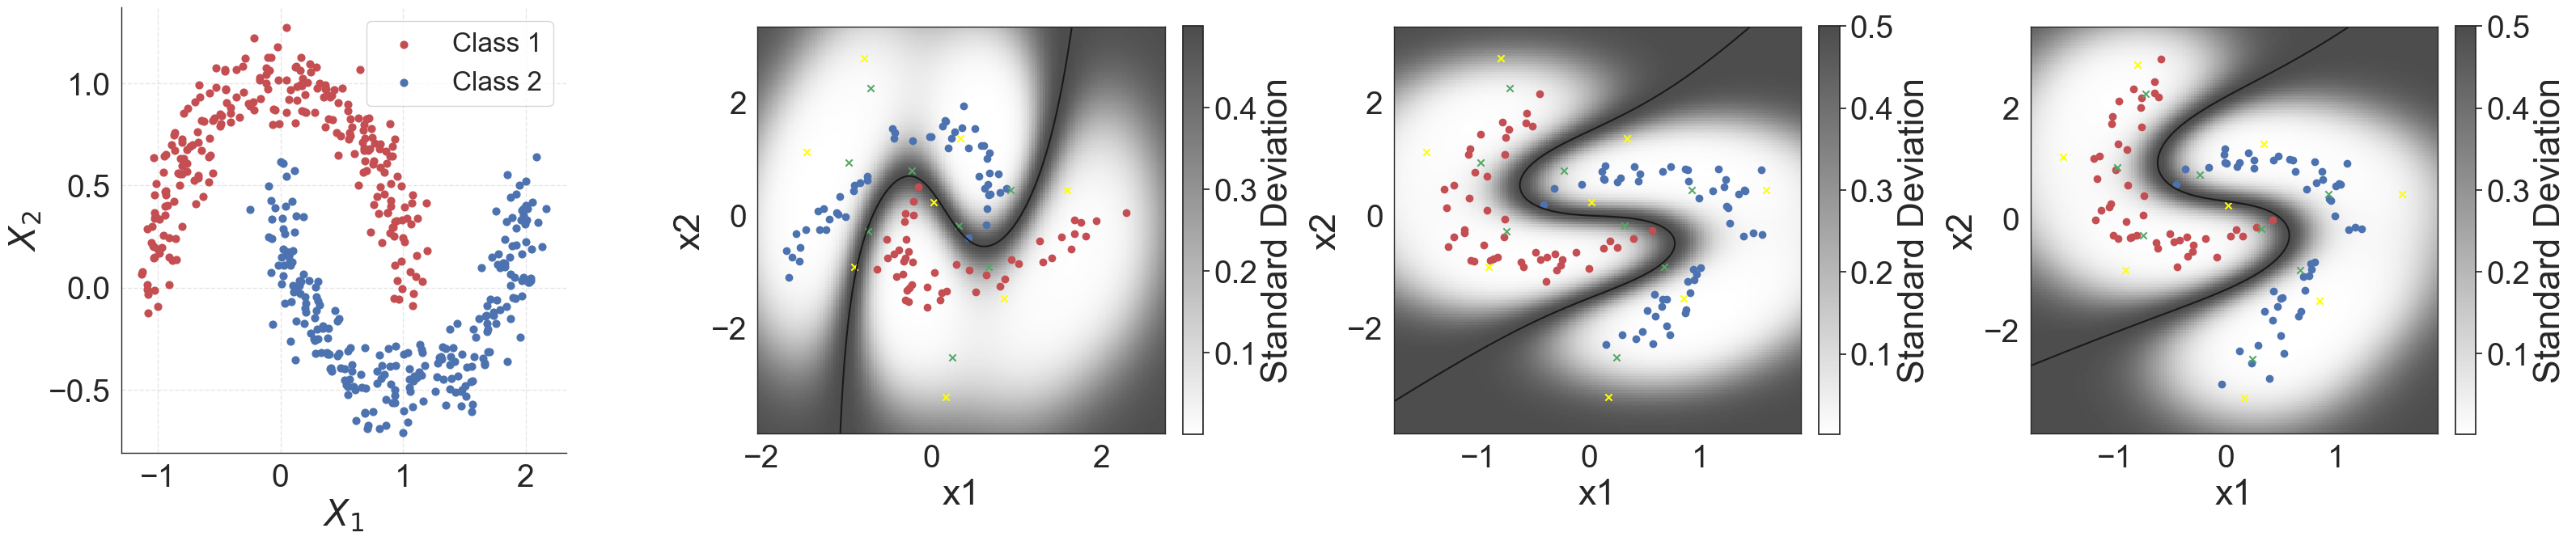

In [9]:
fig, axs = plt.subplots(1,4, figsize=(32, 8))
x_org, y_org = orig_dataset
plot_2d_scatter(x_org, y_org, ax = axs[0])
# [left, bottom, width, height]
for idx , model in enumerate(model_list):
    alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
    alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

    x = model.x.q_mu.cpu().detach().numpy()
    std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

    x_test = model.x_test.q_mu.cpu().detach().numpy()
    std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()

    inducing_points = (history_test['z_list_reg'][-1], history_test['z_list_cls'][-1])

    plot_heatmap(x, labels_train, model, alpha_cls, cmap='binary', range_scale=1.2,
             file_name='latent_heatmap_train', inducing_points=inducing_points, ax1=axs[idx+1], fig=fig, heat_map_mode='std')


plt.tight_layout()
fig.savefig("./saved_results/Compare_synthetic.png")
fig.savefig("./saved_results/Compare_synthetic.svg")


# Cross validation on Synthetic data

In [12]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points': 5,
    'num_inducing_points_reg': 8,
    'num_inducing_points_cls': 8,
    'num_epochs_train': 7000,
    'num_epochs_test': 5000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 65,
    'test_size': 0.8,
    'cls_weight': 1.0,
    'reg_weight': 1.0,
    'num_samples': 500,

}
cross_validate_model(n_dim=[5, 10, 20], settings=model_settings, n_splits=5, load_saved_result=False, save_model=True)

=============== Dim 5 Fold 0 ===============
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       159
         1.0       0.99      1.00      1.00       141

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

=============== Dim 5 Fold 1 ===============
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       157
         1.0       1.00      1.00      1.00       143

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

=============== Dim 5 Fold 2 ===============
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       154
         1.0       1.00      1.00      1.00       146

    accuracy                           1.00    

,dataset,precision,recall,f score
0,synthetic 10,1.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
1,synthetic 20,1.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
2,synthetic 40,1.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00


# Task 2: Train Model with larger Latent Dimension
## 2.1 Settings:

In [11]:
model_settings = {
    'latent_dim': 10,
    'num_inducing_points_reg': 25,
    'num_inducing_points_cls': 25,
    'num_epochs_train': 20000,
    'num_epochs_test': 20000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': False,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.2
}

# 2.2 Training model

In [ ]:
load_saved_result = True
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=10,
                                                                                               random_state= model_settings['random_state'],
                                                                                               test_size=model_settings['test_size'])
model_settings['data_dim'] = yn_train.shape[-1]
model_settings['latent_dim'] = 10
batch_shape = torch.Size([model_settings['data_dim']])


model = create_LDGD_model(yn_train, ys_train, model_settings, x_init='pca')

if load_saved_result is False:
    losses, history_train = model.train_model(yn=yn_train, ys=ys_train,
                                              epochs=model_settings['num_epochs_train'],
                                              batch_size=model_settings['batch_size'])
    winsound.Beep(freq, duration*3)
    model.save_wights(path_save='', file_name=f'model_task2.pth')
else:
    model.load_weights(path_save='', file_name=f'model_task2.pth')


## 2.3 Evaluating model

In [ ]:

predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                epochs=5000)

alpha_reg = 1 / model.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls = 1 / model.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x = model.x.q_mu.cpu().detach().numpy()
std = torch.nn.functional.softplus(model.x.q_log_sigma).cpu().detach().numpy()

x_test = model.x_test.q_mu.cpu().detach().numpy()
std_test = torch.nn.functional.softplus(model.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration*3)

## 2.4 Visualizing results

In [ ]:
latent_dim = x.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg, ax=axs[1])
plot_scatter_gplvm(x, labels_train, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std)
plot_scatter_gplvm(x_test, labels_test, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test)
plt.tight_layout()
fig.savefig("ARD_synthetic.png")
fig.savefig("ARD_synthetic.svg")

# Task 3: Compare LDGD Results with VAE
## 3.1 Settings:

In [14]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points_reg': 5,
    'num_inducing_points_cls': 5,
    'num_epochs_train': 10000,
    'num_epochs_test': 5000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'dataset': 'synthetic',
    'shared_inducing_points': True,
    'use_gpytorch': True,
    'random_state': 54,
    'test_size': 0.3,
    'use_shared_kernel': False
}

## 3.2 Create Dataset

In [15]:
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=10,
                                                                                               random_state= model_settings['random_state'],
                                                                                               test_size=model_settings['test_size'])

print(f"train size = {yn_train.shape[0]}")
print(f"test size = {ys_test.shape[0]}")

list_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
load_saved_result = False


train size = 1050
test size = 450


## 3.3 Training model

In [20]:
try:
    with open('metric_vae_dict0.json', 'r') as file:
        metric_vae_dict = json.load(file)
except:
    batch_shape = torch.Size([yn_train.shape[-1]])
    metric_vae_list = []
    for train_size in list_size:
        print(f"Training for sample size: {train_size}")
        yn_train_limited, ys_train_limited, labels_train_limited = yn_train[:train_size], ys_train[:train_size], labels_train[:train_size]

        # Train VAE Model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = VAE(input_dim=yn_train_limited.shape[-1],
                    hidden_dim=30,
                    latent_dim=10,
                    num_classes=len(np.unique(labels_train))).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        model.fit(x=yn_train_limited, y=labels_train_limited, x_test=yn_test, y_test=labels_test, optimizer=optimizer, epochs=2000, batch_size=500, patience=20)
        x_hat, y_hat, mean, log_var, metrics = model.evaluate(yn_test, labels_test)

        metric_vae_list.append(metrics)
    winsound.Beep(freq, duration*3)
    metric_vae_dict = dicts_to_dict_of_lists(metric_vae_list)
    with open('metric_vae_dict.json', 'w') as file:
        json.dump(metric_vae_dict, file, indent=4)

Training for sample size: 10
	Epoch 1: 	Average Loss:  0.08857818603515626	 ACC train:  0.5	 ACC test:  0.4866666666666667
	Epoch 2: 	Average Loss:  0.0881296844482422	 ACC train:  0.5	 ACC test:  0.4866666666666667
	Epoch 3: 	Average Loss:  0.08747561645507812	 ACC train:  0.5	 ACC test:  0.4866666666666667
	Epoch 4: 	Average Loss:  0.08674281311035156	 ACC train:  0.5	 ACC test:  0.4866666666666667
	Epoch 5: 	Average Loss:  0.08614359283447266	 ACC train:  0.5	 ACC test:  0.48444444444444446
	Epoch 6: 	Average Loss:  0.08537873840332032	 ACC train:  0.5	 ACC test:  0.4822222222222222
	Epoch 7: 	Average Loss:  0.08533122253417968	 ACC train:  0.5	 ACC test:  0.4866666666666667
	Epoch 8: 	Average Loss:  0.08432003784179687	 ACC train:  0.7	 ACC test:  0.5
	Epoch 9: 	Average Loss:  0.08438599395751953	 ACC train:  0.5	 ACC test:  0.48444444444444446
	Epoch 10: 	Average Loss:  0.08345024108886719	 ACC train:  0.3	 ACC test:  0.5022222222222222
	Epoch 11: 	Average Loss:  0.083374633789062

In [17]:
try:
    with open('./saved_results/metric_ldgd_dict.json', 'r') as file:
        metric_ldgd_dict = json.load(file)
except:
    batch_shape = torch.Size([yn_train.shape[-1]])
    metric_ldgd_list = []
    for train_size in list_size:
        model_settings['num_inducing_points_reg']= np.max([int(train_size/10) + 5, 25])
        model_settings['num_inducing_points_cls']= np.max([int(train_size/10) + 5, 25])
        yn_train_limited, ys_train_limited, labels_train_limited = yn_train[:train_size], ys_train[:train_size], labels_train[:train_size]
        # Train LDGD Model
        model = create_LDGD_model(yn_train_limited, ys_train_limited, model_settings)
        if load_saved_result is False:
            losses, history_train = model.train_model(yn=yn_train_limited, ys=ys_train_limited,
                                                      epochs=model_settings['num_epochs_train'],
                                                      batch_size=model_settings['batch_size'],
                                                      early_stop=1e-6)
            model.save_wights(path_save='', file_name=f"model_ldgd_task3_{train_size}")
        else:
            model.load_weights(path_save='', file_name=f"model_ldgd_task3_{train_size}")

        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])

        metric_ldgd_list.append(metrics)
    winsound.Beep(freq, duration*3)
    metric_ldgd_dict = dicts_to_dict_of_lists(metric_ldgd_list)
    with open('metric_ldgd_dict.json', 'w') as file:
        json.dump(metric_ldgd_dict, file, indent=4)

In [18]:
try:
    with open('./saved_results/metric_fastldgd_dict.json', 'r') as file:
        metric_fastldgd_dict = json.load(file)
except:
    batch_shape = torch.Size([yn_train.shape[-1]])
    metric_fastldgd_list = []
    for train_size in list_size:
        print(f"\n ===== train size - {train_size} ======")
        model_settings['num_inducing_points_reg']= np.max([int(train_size/10) + 5, 25])
        model_settings['num_inducing_points_cls']= np.max([int(train_size/10) + 5, 25])
        yn_train_limited, ys_train_limited, labels_train_limited = yn_train[:train_size], ys_train[:train_size], labels_train[:train_size]
        # Train LDGD Model
        model = create_FastLDGD_model(yn_train_limited, ys_train_limited, model_settings)
        if load_saved_result is False:
            losses, history_train = model.train_model(yn=yn_train_limited, ys=ys_train_limited,
                                                      epochs=model_settings['num_epochs_train'],
                                                      batch_size=model_settings['batch_size'])
            model.save_wights(path_save='', file_name=f"model_fldgd_task3_{train_size}")
        else:
            try:
                model.load_weights(path_save='', file_name=f"model_fldgd_task3_{train_size}")
            except:
                losses, history_train = model.train_model(yn=yn_train_limited, ys=ys_train_limited,
                                                      epochs=model_settings['num_epochs_train'],
                                                      batch_size=model_settings['batch_size'])
                model.save_wights(path_save='', file_name=f"model_fldgd_task3_{train_size}")


        predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                        epochs=model_settings['num_epochs_test'])

        metric_fastldgd_list.append(metrics)
    winsound.Beep(freq, duration*3)
    metric_fastldgd_dict = dicts_to_dict_of_lists(metric_fastldgd_list)
    with open('metric_fastldgd_dict.json', 'w') as file:
        json.dump(metric_fastldgd_dict, file, indent=4)

## Visualize

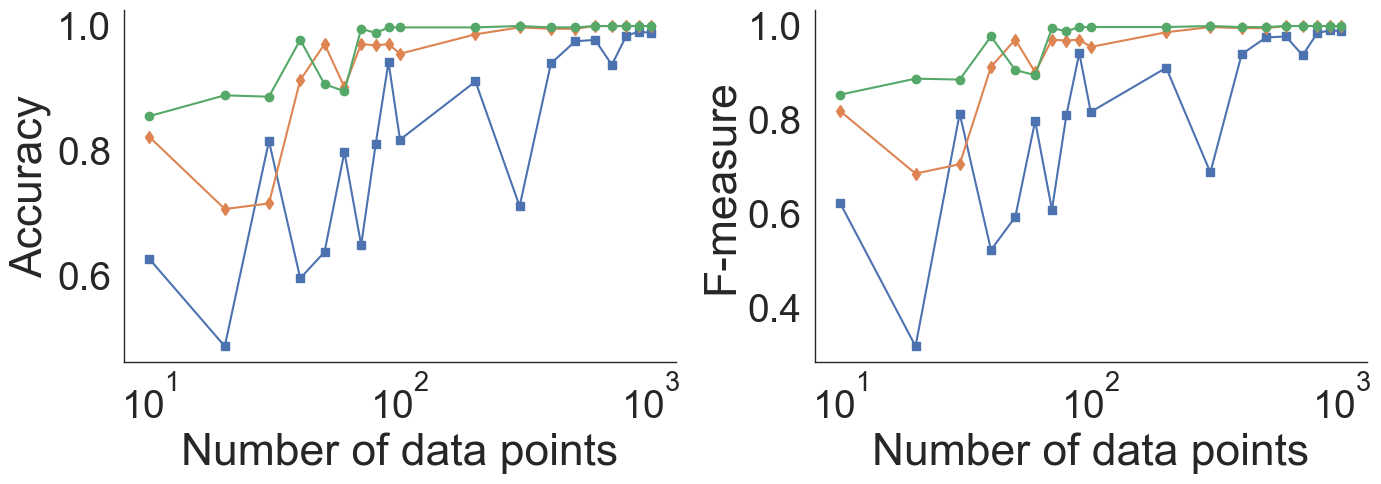

In [28]:

AXIS_LABEL_FONTSIZE = 32
TICKS_LABEL_FONTSIZE = 28
LEGEND_FONTSIZE = 24



fig, axes = plt.subplots(1,2, figsize=(14, 5))
# ax1.set_title('2D Latent Subspace Corresponding to 3 Phase Oilflow', fontsize=32)

axes[0].plot(list_size, metric_vae_dict['accuracy'], label='VAE', marker='s')
axes[0].plot(list_size, metric_ldgd_dict['accuracy'], label='LDGD', marker='d')
axes[0].plot(list_size, metric_fastldgd_dict['accuracy'], label='FastLDGD', marker='o')

axes[0].set_xlabel(f'Number of data points', fontsize=AXIS_LABEL_FONTSIZE)
axes[0].set_ylabel(f'Accuracy', fontsize=AXIS_LABEL_FONTSIZE)
axes[0].tick_params(axis='both', labelsize=TICKS_LABEL_FONTSIZE)
# Applying consistent spines format
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_linewidth(1)
axes[0].spines['bottom'].set_linewidth(1)
#axes[0].legend(fontsize=LEGEND_FONTSIZE)
axes[0].set_xscale('log')  # Making x-axis logarithmic for the accuracy plot


axes[1].plot(list_size, metric_vae_dict['f1_score'], label='VAE', marker='s')
axes[1].plot(list_size, metric_ldgd_dict['f1_score'], label='LDGD', marker='d')
axes[1].plot(list_size, metric_fastldgd_dict['f1_score'], label='Fast LDGD', marker='o')

axes[1].set_xlabel(f'Number of data points', fontsize=AXIS_LABEL_FONTSIZE)
axes[1].set_ylabel(f'F-measure', fontsize=AXIS_LABEL_FONTSIZE)
axes[1].tick_params(axis='both', labelsize=TICKS_LABEL_FONTSIZE)
# Applying consistent spines format
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_linewidth(1)
axes[1].spines['bottom'].set_linewidth(1)
#axes[1].legend(fontsize=LEGEND_FONTSIZE)
axes[1].set_xscale('log')  # Making x-axis logarithmic for the accuracy plot

plt.tight_layout()
fig.savefig("task3.png")
fig.savefig("task3.svg")

plt.show()

In [29]:
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, orig_dataset = create_dataset(num_dimension=10,
                                                                                               random_state= model_settings['random_state'],
                                                                                               test_size=model_settings['test_size'],
                                                                                               n_samples=500)

print(f"train size = {yn_train.shape[0]}")
print(f"test size = {ys_test.shape[0]}")

load_saved_result = False


train size = 350
test size = 150


In [30]:
print(f"Training for sample size: {train_size}")

# Train VAE Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=yn_train.shape[-1],
            hidden_dim=30,
            latent_dim=10,
            num_classes=len(np.unique(labels_train))).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.fit(x=yn_train, y=labels_train, x_test=yn_test, y_test=labels_test, optimizer=optimizer, epochs=2000, batch_size=500, patience=20)
x_hat, y_hat, mean, log_var, metrics = model.evaluate(yn_test, labels_test)



Training for sample size: 1000
	Epoch 1: 	Average Loss:  3.15735009765625	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 2: 	Average Loss:  3.15185888671875	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 3: 	Average Loss:  3.14801513671875	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 4: 	Average Loss:  3.14185107421875	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 5: 	Average Loss:  3.13718212890625	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 6: 	Average Loss:  3.132735595703125	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 7: 	Average Loss:  3.127435791015625	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 8: 	Average Loss:  3.123341064453125	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	Epoch 9: 	Average Loss:  3.118725341796875	 ACC train:  0.5114285714285715	 ACC test:  0.47333333333333333
	E

In [31]:
x_train_hat, y_hat, mean_train, log_var_train, metrics = model.evaluate(yn_train, labels_train)


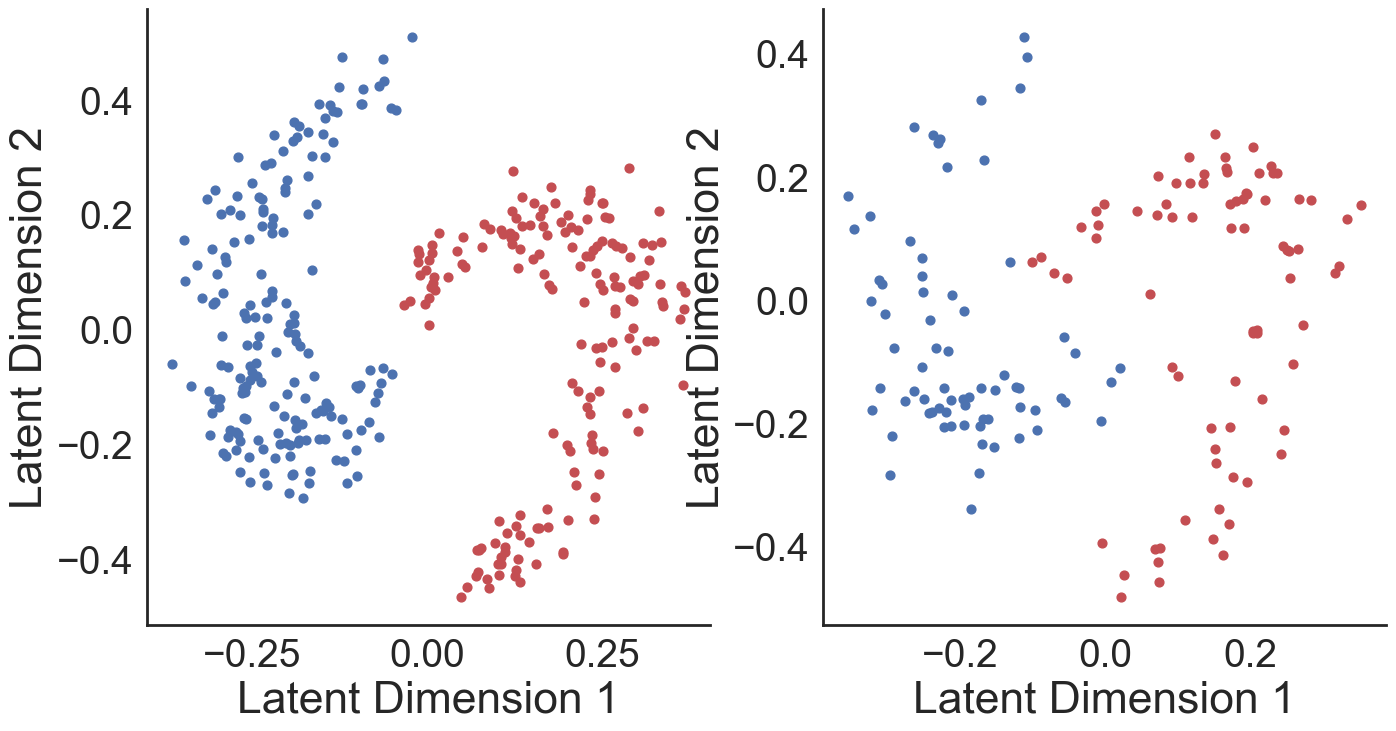

In [34]:

fig, axs = plt.subplots(1,2, figsize=(16, 8))
l1=0
l2=1
plot_scatter_gplvm(mean_train, labels_train, l1=l1, l2=l2, ax=axs[0], colors=['r', 'b', 'g'], show_errorbars=False, std=None)
plot_scatter_gplvm(mean, labels_test, l1=l1, l2=l2, ax=axs[1], colors=['r', 'b', 'g'], show_errorbars=False, std=None)